In [1]:

import pickle

# Load trained models
with open('trained_models.pkl', 'rb') as f:
    trained_models = pickle.load(f)

# Load optuna optimized models
with open('optuna_best_models.pkl', 'rb') as f:
    optuna_best_models = pickle.load(f)


In [2]:
import pandas as pd
import dowhy
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pygraphviz
from dowhy import CausalModel

c:\Users\seanc\anaconda3\envs\causalml-py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
data_path = r'C:\Users\seanc\OneDrive - McGill University\Courses\INSY 695 - ML in Production\Group-Project\INSY695-W24-078-Group-2\final-weather-flight-data\processed_dataset_YUL-Flights-Weather.csv'
df = pd.read_csv(data_path)

Top 10 Arrival IATA Codes with the highest number of delays:
Arrival IATA Code
7.0     16
52.0    11
30.0     8
31.0     7
65.0     6
15.0     5
49.0     5
59.0     5
29.0     5
5.0      4
Name: Delayed, dtype: int32


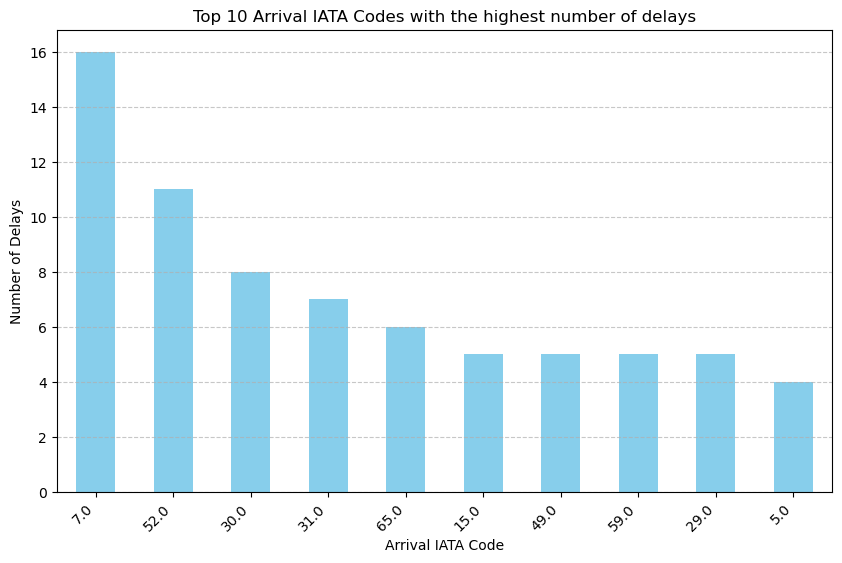

Top 10 Airline Names with the highest number of delays:
Airline Name
3.0     16
41.0    11
69.0     8
19.0     8
4.0      6
60.0     6
99.0     5
27.0     5
75.0     4
34.0     4
Name: Delayed, dtype: int32


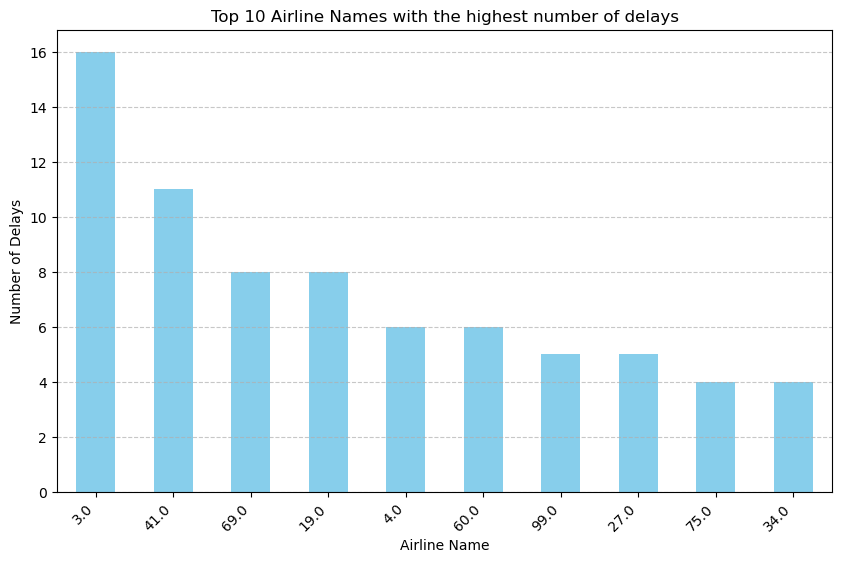

Top 10 Departure Gates with the highest number of delays:
Departure Gate
28.0    8
41.0    7
62.0    6
50.0    5
68.0    5
64.0    5
14.0    5
54.0    4
24.0    4
23.0    4
Name: Delayed, dtype: int32


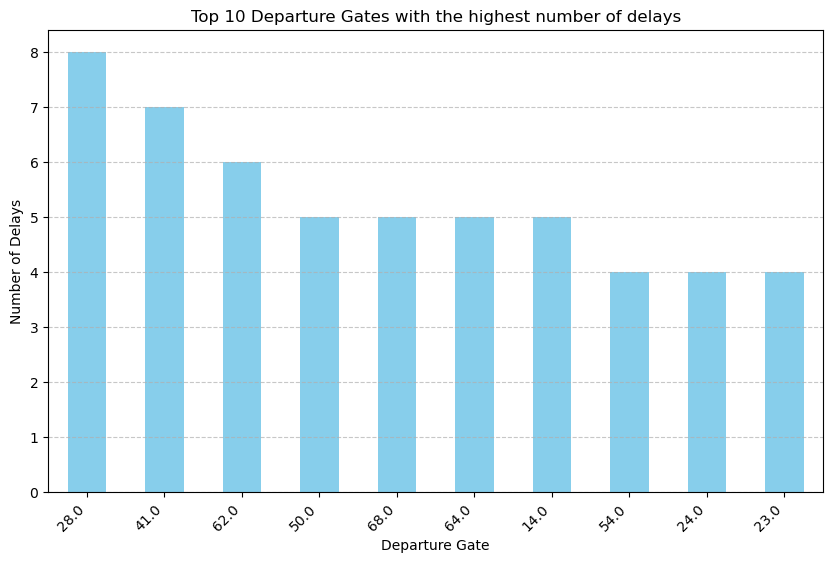

In [18]:
def causal_inference_processing(df, top_n=10):
    # Create binary feature for delayed flights
    df['Delayed'] = (df['Departure Delay (min)'] > 5).astype(int)
    
    # Group by 'Arrival IATA Code' and sum delayed flights
    delayed_by_iata = df.groupby('Arrival IATA Code')['Delayed'].sum()
    
    # Sort in descending order and select top n codes
    top_iata_codes = delayed_by_iata.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Create binary categorical variable for each top IATA code
    for code in top_iata_codes:
        column_name = f'Arrival_IATA_is_{code}'
        df[column_name] = (df['Arrival IATA Code'] == code).astype(int)
    
    # Plot the top 10 Arrival IATA codes with the highest number of delays
    plot_top_delayed_instances(delayed_by_iata, 'Arrival IATA Code')
    
    # Group by 'Airline Name' and sum delayed flights
    delayed_by_airline = df.groupby('Airline Name')['Delayed'].sum()
    
    # Sort in descending order and select top n airlines
    top_airlines = delayed_by_airline.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Create binary categorical variable for each top airline
    for airline in top_airlines:
        column_name = f'Airline_{airline}'
        df[column_name] = (df['Airline Name'] == airline).astype(int)
    
    # Plot the top n airlines with the highest number of delays
    plot_top_delayed_instances(delayed_by_airline, 'Airline Name', top_n)
    
    # Group by 'Departure Gate' and sum delayed flights
    delayed_by_gate = df.groupby('Departure Gate')['Delayed'].sum()
    
    # Sort in descending order and select top n gates
    top_gates = delayed_by_gate.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Create binary categorical variable for each top gate
    for gate in top_gates:
        column_name = f'Departure_Gate_{gate}'
        df[column_name] = (df['Departure Gate'] == gate).astype(int)
    
    # Plot the top n gates with the highest number of delays
    plot_top_delayed_instances(delayed_by_gate, 'Departure Gate', top_n)
    
    return df, top_iata_codes, top_airlines, top_gates

def plot_top_delayed_instances(data, column_name, top_n=10):
    sorted_data = data.sort_values(ascending=False)
    print(f"Top {top_n} {column_name}s with the highest number of delays:")
    print(sorted_data.head(top_n))
    
    plt.figure(figsize=(10, 6))
    sorted_data.head(top_n).plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} {column_name}s with the highest number of delays')
    plt.xlabel(column_name)
    plt.ylabel('Number of Delays')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
# Preprocess the data
df, top_iata_codes, top_airlines, top_gates = causal_inference_processing(df, top_n=10)


In [33]:
import statsmodels.api as sm

# Add intercept
df['Intercept'] = 1

# Define predictors (features)
predictors = ['Intercept'] + [f'Arrival_IATA_is_{code}' for code in top_iata_codes] + \
             [f'Airline_{airline}_Delayed' for airline in top_airlines] + \
             [f'Gate_{gate}_Delayed' for gate in top_gates]

# Logistic regression model
logit_model = sm.Logit(df['Delayed'], df[predictors])

# Fit the model
logit_result = logit_model.fit()

# Print summary
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.025841
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                Delayed   No. Observations:                26860
Model:                          Logit   Df Residuals:                    26844
Method:                           MLE   Df Model:                           15
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:                 0.09107
Time:                        21:05:34   Log-Likelihood:                -694.08
converged:                       True   LL-Null:                       -763.63
Covariance Type:            nonrobust   LLR p-value:                 3.475e-22
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.8607      0.152    -38.519      0.000      -6.159      -5.56

In [35]:

# TODO: Treat MultiCollinearity before investigating interactions of these categorical variables to handle error 'Singlar Matrix' and 'Perfect Collinearity' in the model

# from itertools import combinations

# # Add interaction terms
# interaction_terms = []
# for combo in combinations(predictors[1:], 2):
#     interaction_name = f"{combo[0]}_x_{combo[1]}"
#     interaction_terms.append(interaction_name)
#     df[interaction_name] = df[combo[0]] * df[combo[1]]

# # Update predictors list
# predictors += interaction_terms

# # Fit the updated model with interaction terms
# logit_model_interactions = sm.Logit(df['Delayed'], df[predictors])
# logit_result_interactions = logit_model_interactions.fit()

# # Print summary
# print(logit_result_interactions.summary())


In [8]:
# Define outcome, treatment, and confounders
outcome = 'Delayed'  # Binary outcome: 1 for Delayed, 0 for Not Delayed
treatment = 'Arrival_IATA_is_7.0'  # Let's focus on Arrival IATA Code 7 as the treatment variable
confounders = ['Pressure', 'Clouds', 'Rain 1h', 'Snow 1h', 'Departure Time of Day', 
               'Weekday of Departure', 'Season', 'Visibility', 'Feels Like', 
               'Airline Name', 'Departure Gate', 'Weather Severity', 'Temperature',
               'Humidity', 'Wind Speed', 'Weather Main']  # Other potential confounders

# Initialize CausalModel
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders,
    instruments=None  # No instrumental variables specified
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate causal effect using a causal inference method (e.g., propensity score matching)
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

# Print the estimated causal effect
print("Estimated Causal Effect:")
print(estimate.value)




c:\Users\seanc\anaconda3\envs\causalml-py38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Estimated Causal Effect:
0.024683544303797468


Estimated Causal Effects for Each IATA Code (PSM):
Arrival_IATA_is_7.0: 0.024683544303797468
Arrival_IATA_is_52.0: 0.011094564408041697
Arrival_IATA_is_30.0: 0.007297096053611318
Arrival_IATA_is_31.0: 0.010647803425167536
Arrival_IATA_is_65.0: -0.0020476545048399106
Arrival_IATA_is_15.0: 0.004690990320178704
Arrival_IATA_is_49.0: -0.002271034996276992
Arrival_IATA_is_59.0: 0.043559195830230824
Arrival_IATA_is_29.0: 0.006105733432613552
Arrival_IATA_is_5.0: 0.01839166046165302


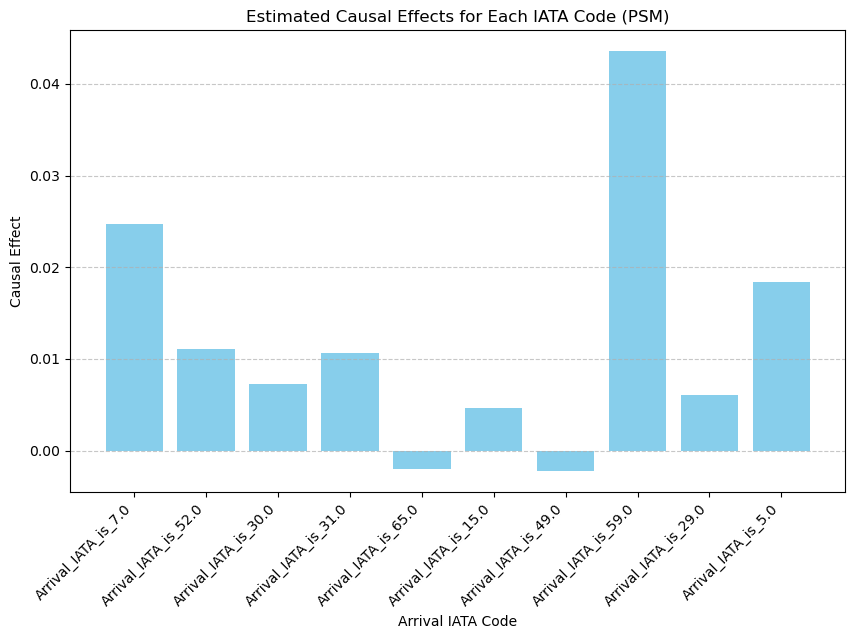

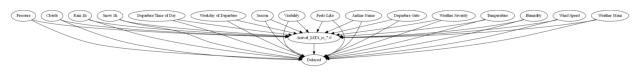

In [11]:
def run_causal_analysis_for_iata_codes_psm(df, top_iata_codes, outcome, confounders):
    causal_effects = {}
    
    for iata_code in top_iata_codes:
        treatment_variable = f'Arrival_IATA_is_{iata_code}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using a causal inference method (e.g., propensity score matching)
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value
    
    return causal_effects

# Run causal analysis for each 'Arrival_IATA_is_X' using propensity score matching
causal_effects_iata = run_causal_analysis_for_iata_codes_psm(df, top_iata_codes, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each IATA Code (PSM):")
for iata_code, effect in causal_effects_iata.items():
    print(f"{iata_code}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(causal_effects_iata.keys(), causal_effects_iata.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each IATA Code (PSM)')
plt.xlabel('Arrival IATA Code')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# show the causal graph
model.view_model()


Estimated Causal Effects for Each IATA Code (Linear Regression):
Arrival_IATA_is_7.0: 0.018377302275489858
Arrival_IATA_is_52.0: 0.008203717960368642
Arrival_IATA_is_30.0: 0.01597886010570762
Arrival_IATA_is_31.0: 0.013916893568886902
Arrival_IATA_is_65.0: -0.0029812375847027015
Arrival_IATA_is_15.0: 0.003593685696236997
Arrival_IATA_is_49.0: 0.0016923971330616702
Arrival_IATA_is_59.0: 0.03892002547402765
Arrival_IATA_is_29.0: 0.006537613382087923
Arrival_IATA_is_5.0: 0.01247717676072213


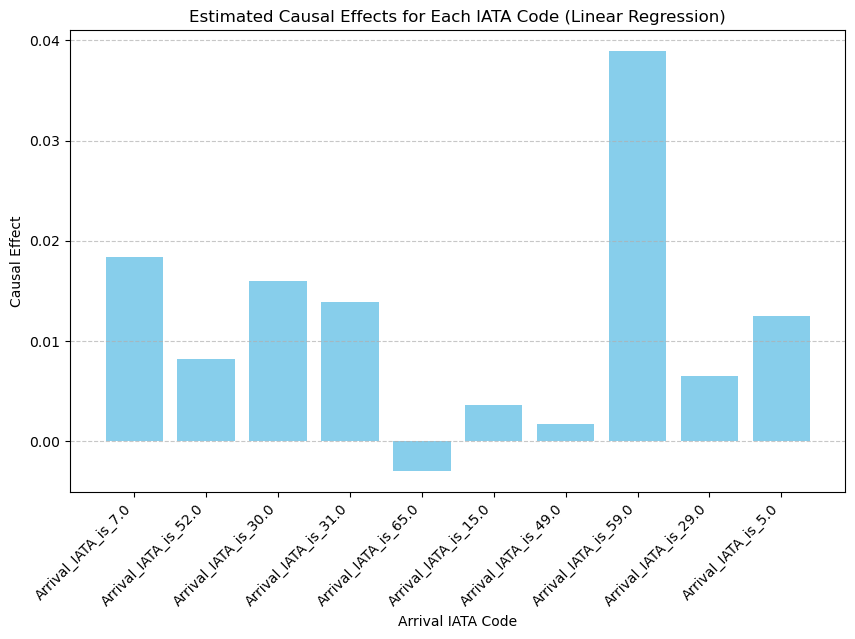

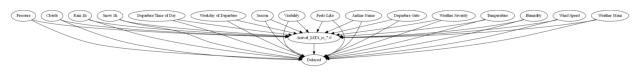

In [12]:
def run_causal_analysis_for_iata_codes_linear(df, top_iata_codes, outcome, confounders):
    causal_effects = {}
    
    for iata_code in top_iata_codes:
        treatment_variable = f'Arrival_IATA_is_{iata_code}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using backdoor linear regression
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value
    
    return causal_effects

# Run causal analysis for each 'Arrival_IATA_is_X' using linear regression
causal_effects_iata_linear = run_causal_analysis_for_iata_codes_linear(df, top_iata_codes, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each IATA Code (Linear Regression):")
for iata_code, effect in causal_effects_iata_linear.items():
    print(f"{iata_code}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(causal_effects_iata_linear.keys(), causal_effects_iata_linear.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each IATA Code (Linear Regression)')
plt.xlabel('Arrival IATA Code')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# show the causal graph
model.view_model()


Estimated Causal Effects for Each Departure Gate (PSM):
Departure_Gate_28.0: 0.00387192851824274
Departure_Gate_41.0: 0.00800446760982874
Departure_Gate_62.0: 0.0027922561429635146
Departure_Gate_50.0: -0.003462397617274758
Departure_Gate_68.0: 0.002308265078183172
Departure_Gate_64.0: 0.013588979895755771
Departure_Gate_14.0: 0.006552494415487714
Departure_Gate_54.0: 0.01150409530900968
Departure_Gate_24.0: 0.003090096798212956
Departure_Gate_23.0: 0.01712583767684289


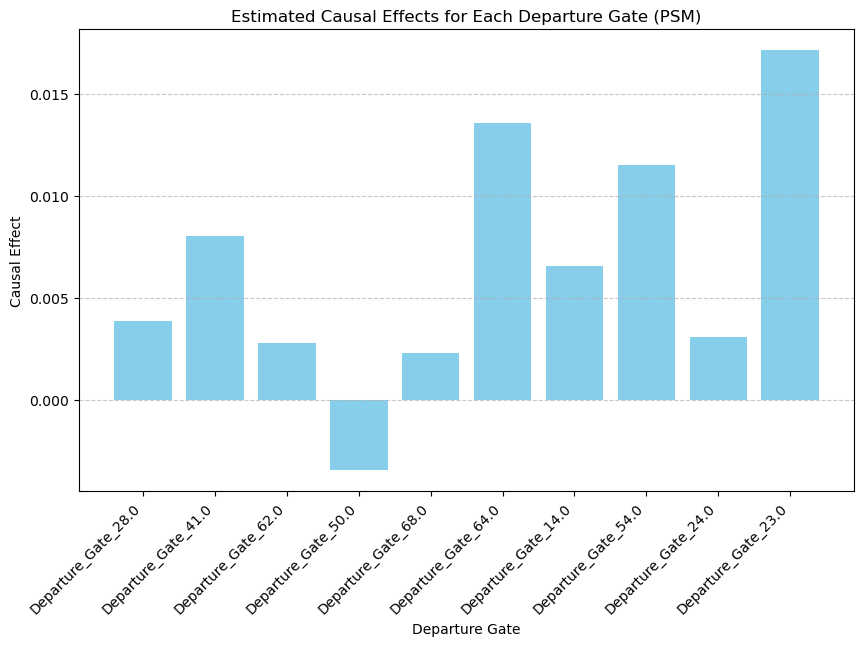

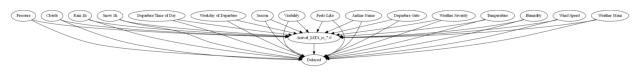

In [13]:
def run_causal_analysis_for_gate_codes_psm(df, top_gates, outcome, confounders):
    causal_effects = {}
    
    for gate_code in top_gates:
        treatment_variable = f'Departure_Gate_{gate_code}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using a causal inference method (e.g., propensity score matching)
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value
    
    return causal_effects

# Run causal analysis for each 'Departure_Gate_X' using propensity score matching
causal_effects_gate = run_causal_analysis_for_gate_codes_psm(df, top_gates, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each Departure Gate (PSM):")
for gate_code, effect in causal_effects_gate.items():
    print(f"{gate_code}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(causal_effects_gate.keys(), causal_effects_gate.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each Departure Gate (PSM)')
plt.xlabel('Departure Gate')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show the causal graph
model.view_model()


Estimated Causal Effects for Each Departure Gate (Linear Regression):
Departure_Gate_28.0: 0.008418738495430764
Departure_Gate_41.0: 0.01629474227250806
Departure_Gate_62.0: 0.006678517295189671
Departure_Gate_50.0: -0.003384491581771289
Departure_Gate_68.0: 0.005889280985498903
Departure_Gate_64.0: 0.002851811506500797
Departure_Gate_14.0: 0.02056181354372672
Departure_Gate_54.0: 0.030151365697335075
Departure_Gate_24.0: 0.010428173312610837
Departure_Gate_23.0: 0.014191228362639315


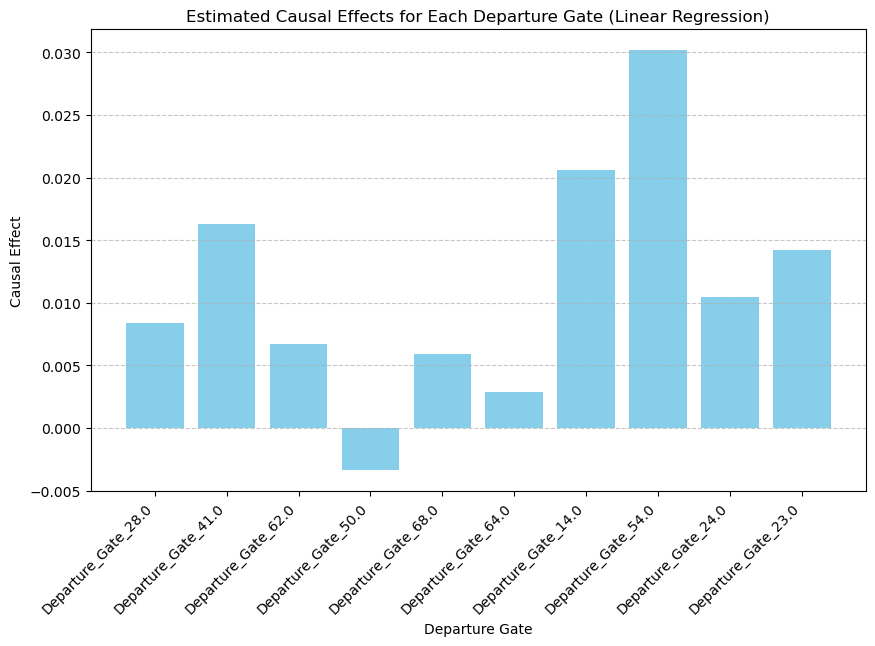

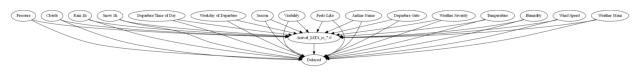

In [15]:
def run_causal_analysis_for_gate_codes_linear(df, top_gates, outcome, confounders):
    causal_effects = {}
    
    for gate_code in top_gates:
        treatment_variable = f'Departure_Gate_{gate_code}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using backdoor linear regression
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value
    
    return causal_effects

# Run causal analysis for each 'Departure_Gate_X' using linear regression
causal_effects_gate_linear = run_causal_analysis_for_gate_codes_linear(df, top_gates, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each Departure Gate (Linear Regression):")
for gate_code, effect in causal_effects_gate_linear.items():
    print(f"{gate_code}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(causal_effects_gate_linear.keys(), causal_effects_gate_linear.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each Departure Gate (Linear Regression)')
plt.xlabel('Departure Gate')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show the causal graph
model.view_model()

In [22]:
top_airlines

In [ ]:

def run_causal_analysis_for_airline_psm(df, top_airlines, outcome, confounders):
    causal_effects = {}
    
    for airline_name in top_airlines:
        treatment_variable = f'Airline_{airline_name}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using propensity score matching
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value

        return causal_effects
        
    

# Run causal analysis for each 'Airline_X' using propensity score matching
causal_effects_airlines_psm = run_causal_analysis_for_airline_psm(df, top_airlines, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each Airline (PSM):")
for airline_name, effect in causal_effects_airlines_psm.items():
    print(f"{airline_name}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(causal_effects_psm.keys(), causal_effects_psm.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each Airline (PSM)')
plt.xlabel('Airline Name')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show the causal graph
model.view_model()


In [ ]:
def run_causal_analysis_for_airline_linear(df, top_airlines, outcome, confounders):
    causal_effects = {}
    
    for airline_name in top_airlines:
        treatment_variable = f'Airline_{airline_name}'
        
        # Initialize CausalModel
        model = CausalModel(
            data=df,
            treatment=treatment_variable,
            outcome=outcome,
            common_causes=confounders,
            instruments=None  # No instrumental variables specified
        )
        
        # Identify causal effect
        identified_estimand = model.identify_effect()
        
        # Estimate causal effect using backdoor linear regression
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        
        # Store the estimated causal effect
        causal_effects[treatment_variable] = estimate.value
    
    return causal_effects

# Run causal analysis for each 'Airline_X' using linear regression
causal_effects_airlines_linear = run_causal_analysis_for_airline_linear(df, top_airlines, outcome, confounders)

# Print the estimated causal effects
print("Estimated Causal Effects for Each Airline (Linear Regression):")
for airline_name, effect in causal_effects_airlines_linear.items():
    print(f"{airline_name}: {effect}")

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
plt.bar(run_causal_analysis_for_airline_linear.keys(), run_causal_analysis_for_airline_linear.values(), color='skyblue')
plt.title('Estimated Causal Effects for Each Airline (Linear Regression)')
plt.xlabel('Airline Name')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show the causal graph
model.view_model()


Estimated Causal Effects:
{'Feels Like': -0.0009504967396461342}
{'Temperature': -0.000829051628106319}
{'Humidity': 0.001075586405829979}
{'Wind Speed': 0.0009807814795861356}
{'Weather Severity': 0.003362812214378368}


<Figure size 1000x600 with 0 Axes>

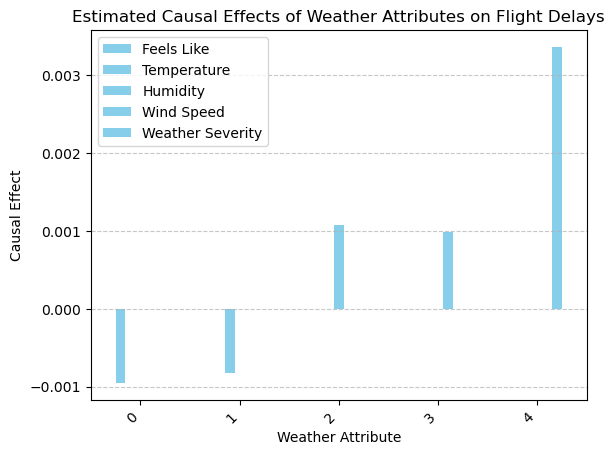

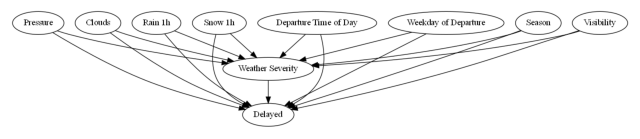

In [20]:
import pandas as pd
import dowhy
from dowhy import CausalModel


# Define outcome and confounders
outcome = 'Delayed'  # Binary outcome: 1 for Delayed, 0 for Not Delayed
confounders = ['Pressure', 'Clouds', 'Rain 1h', 'Snow 1h', 'Departure Time of Day', 'Weekday of Departure', 'Season', 'Visibility']  # Other potential confounders

# Initialize lists to store causal effects
causal_effects = []

# Iterate over each weather attribute as treatment
for treatment_var in ['Feels Like', 'Temperature', 'Humidity', 'Wind Speed', 'Weather Severity']:
    # Initialize CausalModel for each weather attribute
    model = CausalModel(
        data=df,
        treatment=treatment_var,
        outcome=outcome,
        common_causes=confounders,
        instruments=None  # No instrumental variables specified
    )

    # Identify causal effect
    identified_estimand = model.identify_effect()

    # Estimate causal effect using linear regression
    estimate = model.estimate_effect(identified_estimand,
                                      method_name="backdoor.linear_regression")

    # Append the estimated causal effect to the list
    causal_effects.append({treatment_var: estimate.value})

# Print the estimated causal effects
print("Estimated Causal Effects:")
for effect in causal_effects:
    print(effect)

# Plot the estimated causal effects
plt.figure(figsize=(10, 6))
pd.DataFrame(causal_effects).plot(kind='bar', color='skyblue')
plt.title('Estimated Causal Effects of Weather Attributes on Flight Delays')
plt.xlabel('Weather Attribute')
plt.ylabel('Causal Effect')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Causal Graph
model.view_model()


In [47]:
# import pandas as pd
# from dowhy import CausalModel

# # Define outcome, treatment, and confounders
# outcome = 'Delayed'  # Binary outcome: 1 for Delayed, 0 for Not Delayed
# weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Weather Severity']
# confounders = ['Pressure', 'Clouds', 'Rain 1h', 'Snow 1h', 'Departure Time of Day', 'Weekday of Departure', 'Season', 'Visibility', 'Feels Like', 'Airline Name', 'Departure Gate', 'Arrival IATA Code']

# # Create interaction terms 
# interaction_terms = []
# for attribute in weather_attributes:
#     for factor in ['Departure Time of Day', 'Weekday of Departure', 'Season', 'Airline Name', 'Departure Gate', 'Arrival IATA Code']:
#         interaction_name = f'{attribute}_x_{factor}'
#         df[interaction_name] = df[attribute] * df[factor]
#         interaction_terms.append(interaction_name)

# # Include interaction terms in confounders
# confounders += interaction_terms

# # Initialize CausalModel with enriched data
# model = CausalModel(
#     data=df,
#     treatment=weather_attributes,
#     outcome=outcome,
#     common_causes=confounders,
#     instruments=None  # No instrumental variables specified
# )

# # Identify causal effect
# identified_estimand = model.identify_effect()

# # Estimate causal effect using linear regression
# estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

# # Print the estimated causal effect
# print("Estimated Causal Effect:")
# print(estimate.value)

Estimated Causal Effect:
-0.005685379694065406
